In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

In [ ]:
# Import DataSet
df = pd.read_csv('d:/HP/Downloads/Womens Clothing E-Commerce Reviews.csv')
df = df.drop(columns=['Title','Unnamed: 0','Clothing ID','Recommended IND'])

df

,Age,Review Text,Rating,Positive Feedback Count,Division Name,Department Name,Class Name
0,33,Absolutely wonderful - silky and sexy and comf...,4,0,Initmates,Intimate,Intimates
1,34,Love this dress! it's sooo pretty. i happene...,5,4,General,Dresses,Dresses
2,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,0,General Petite,Bottoms,Pants
4,47,This shirt is very flattering to all due to th...,5,6,General,Tops,Blouses
...,...,...,...,...,...,...,...
23481,34,I was very happy to snag this dress at such a ...,5,0,General Petite,Dresses,Dresses
23482,48,"It reminds me of maternity clothes. soft, stre...",3,0,General Petite,Tops,Knits
23483,31,"This fit well, but the top was very see throug...",3,1,General Petite,Dresses,Dresses
23484,28,I bought this dress for a wedding i have this ...,3,2,General,Dresses,Dresses


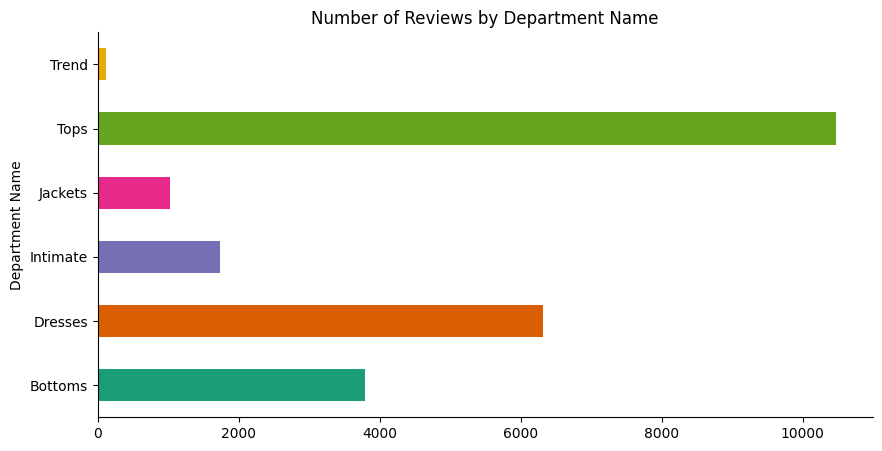

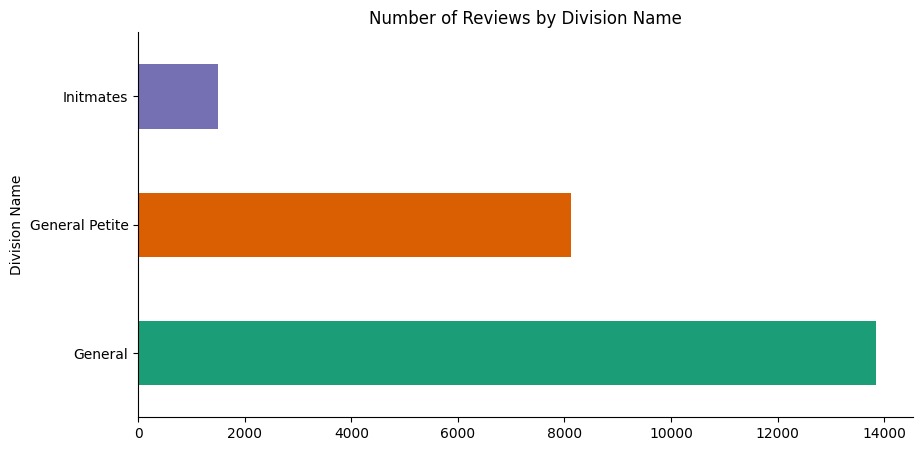

In [ ]:
# Visualizations
plt.figure(figsize=(10, 5))
df.groupby('Department Name').size().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Number of Reviews by Department Name')
plt.show()

plt.figure(figsize=(10, 5))
df.groupby('Division Name').size().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Number of Reviews by Division Name')
plt.show()


In [ ]:
# Data Info and Shape
print(df.info())
print(df.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Review Text              22641 non-null  object
 2   Rating                   23486 non-null  int64 
 3   Positive Feedback Count  23486 non-null  int64 
 4   Division Name            23472 non-null  object
 5   Department Name          23472 non-null  object
 6   Class Name               23472 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.3+ MB
None
(23486, 7)


In [ ]:
# Handle Missing Values
df['Review Text'].replace("", np.nan, inplace=True)
df['Review Text'].fillna("No Review", inplace=True)
df.dropna(axis=0, inplace=True)
print(df.isna().sum())


Age                        0
Review Text                0
Rating                     0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_4992\351861959.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Review Text'].replace("", np.nan, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_4992\351861959.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

In [ ]:
# Define Target (y) and Feature (X)
X = df[['Review Text','Positive Feedback Count']]
y = df['Rating']
print(df['Rating'].value_counts())


Rating
5    13117
4     5077
3     2871
2     1565
1      842
Name: count, dtype: int64


In [ ]:
# Recategorize Ratings as Poor (0) and Good (1)
df.replace({'Rating': {1: 0, 2: 0, 3: 1, 4: 1, 5: 1}}, inplace=True)
y = df['Rating']


In [ ]:
# Train Test Split (After Recategorizing)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,train_size=0.7, random_state=42529)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(16430, 2) (7042, 2) (16430,) (7042,)


In [ ]:
# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['Review Text'])
X_test_vec = vectorizer.transform(X_test['Review Text'])

# Combine TF-IDF features with numerical features
X_train_combined = np.hstack((X_train_vec.toarray(), X_train[['Positive Feedback Count']].values))
X_test_combined = np.hstack((X_test_vec.toarray(), X_test[['Positive Feedback Count']].values))

# Train and evaluate different models
models = {
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train_combined, y_train)
    predictions = model.predict(X_test_combined)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, zero_division=1)
    print(f'{name} Accuracy: {accuracy}')
    print(f'{name} Classification Report:\n{report}')


Naive Bayes Accuracy: 0.8974723090031241
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       722
           1       0.90      1.00      0.95      6320

    accuracy                           0.90      7042
   macro avg       0.95      0.50      0.47      7042
weighted avg       0.91      0.90      0.85      7042

Random Forest Accuracy: 0.8987503550127804
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.02      0.03       722
           1       0.90      1.00      0.95      6320

    accuracy                           0.90      7042
   macro avg       0.87      0.51      0.49      7042
weighted avg       0.89      0.90      0.85      7042

Logistic Regression Accuracy: 0.9089747230900312
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.22      0.33

In [ ]:
print(predictions)
print(y_test)
print(X_test)

[1 1 1 ... 1 1 1]
21185    1
19238    1
20935    1
20918    1
4806     0
        ..
7579     1
22765    1
556      1
1735     1
18954    1
Name: Rating, Length: 7042, dtype: int64
                                             Review Text  \
21185  I vacillate betwixt saying this shirt runs lar...   
19238  Wonderful colors and fit tts. love the style. ...   
20935  Great skirt, can be dressy, work or casual, lo...   
20918  Love the top, it fits wonderfully, and it's li...   
4806   I like my dresses oversized but this one is ri...   
...                                                  ...   
7579   I love an all cotton shirt! feels great and ha...   
22765  Such a gorgeous weight, cut and style! the but...   
556    Love the detail and the way it hangs. i someti...   
1735   At first, i thought this top was going to be s...   
18954  I bought this vest to add more versatility to ...   

       Positive Feedback Count  
21185                        0  
19238                        5  


In [ ]:
print(confusion_matrix(y_test, predictions))

[[  52  670]
 [  64 6256]]


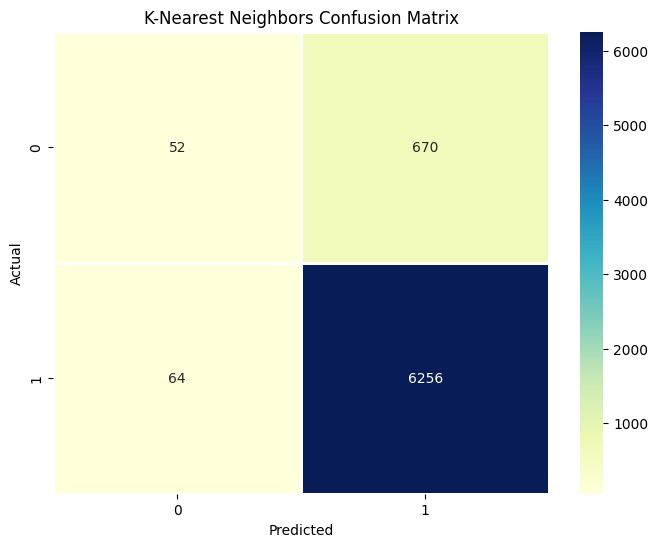

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='YlGnBu', linewidths=.9)
plt.title(f'{name} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Predict the new data and give the predicted rating
new_review_text = "The dress is best"
new_review_feedback = 66
new_review_combined = np.hstack((vectorizer.transform([new_review_text]).toarray(), [[new_review_feedback]]))

# Assuming the last model trained is used for prediction
predicted_rating = model.predict(new_review_combined)
print("Predicted Rating:", predicted_rating[0])

Predicted Rating: 1
